In [ ]:
# !pip install pandas numpy matplotlib seaborn statsmodels openpyxl

In [1]:
import pandas as pd

# Load the time-series data
file_path = "time_series.xlsx"
xls = pd.ExcelFile(file_path)

# Display sheet names to understand the structure
xls.sheet_names

['in']

In [2]:
# Load the data from the detected sheet
df = pd.read_excel(xls, sheet_name='in')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395806 entries, 0 to 395805
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Product   395806 non-null  int64         
 1   Supplier  395806 non-null  object        
 2   Date      395806 non-null  datetime64[ns]
 3   Quantity  395806 non-null  int64         
 4   Price     395806 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 15.1+ MB


In [4]:
df.head()

,Product,Supplier,Date,Quantity,Price
0,7006,408,2001-08-15,1000,0.130000
1,8631,611,2007-07-26,15,0.701333
2,8631,611,2007-07-26,100,0.038900
3,8631,611,2007-07-26,1,5.000000
4,8631,3166,2007-09-04,100,0.098200


<b> Understanding the Data </b>
    
<b> The dataset has 395,806 rows and 5 columns: </b>

    Product (int64): Unique product ID.
    Supplier (object): Supplier identifier.
    Date (datetime64): Timestamp for each record.
    Quantity (int64): Quantity of the product at that date.
    Price (float64): Price per unit at that date.

<b> Data Cleaning </b>

In [5]:
missing_values = df.isnull().sum()
duplicates = df.duplicated().sum()
print(missing_values)
print(duplicates, "Duplicates")

# Data Cleaning: Remove duplicates
df_cleaned = df.drop_duplicates()

# Select only numerical columns (ignoring datetime & categorical columns)
numerical_cols = df_cleaned.select_dtypes(include=['number']).columns

# Identify zero & negative values
zero_values = (df_cleaned[numerical_cols] == 0).sum()
negative_values = (df_cleaned[numerical_cols] < 0).sum()

# Remove rows where numerical values are zero or negative
df_filtered = df_cleaned[(df_cleaned[numerical_cols] > 0).all(axis=1)]

# Display counts of removed zero and negative values
zero_values, negative_values, df_filtered.shape

Product     0
Supplier    0
Date        0
Quantity    0
Price       0
dtype: int64
21364 Duplicates


(Product        35
 Quantity    12378
 Price         599
 dtype: int64,
 Product     0
 Quantity    0
 Price       8
 dtype: int64,
 (361463, 5))

<b> Data Cleaning Summary </b>

        No missing values found in the given columns. 
        21,364 duplicate rows detected. We can remove them before proceeding with analysis.
        
        Zero Values Found & Removed:
        Product: 35 occurrences
        Quantity: 12,378 occurrences
        Price: 599 occurrences
        
        Negative Values Found & Removed:
        Price: 8 occurrences
        Final dataset size: 361,463 rows

In [6]:
df_cleaned.shape

(374442, 5)

<b> Exploratory Data Analysis (EDA) </b>

C:\Users\Alex\AppData\Local\Temp\ipykernel_13028\3214354221.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Total_Price"] = df_filtered["Quantity"] * df_filtered["Price"]


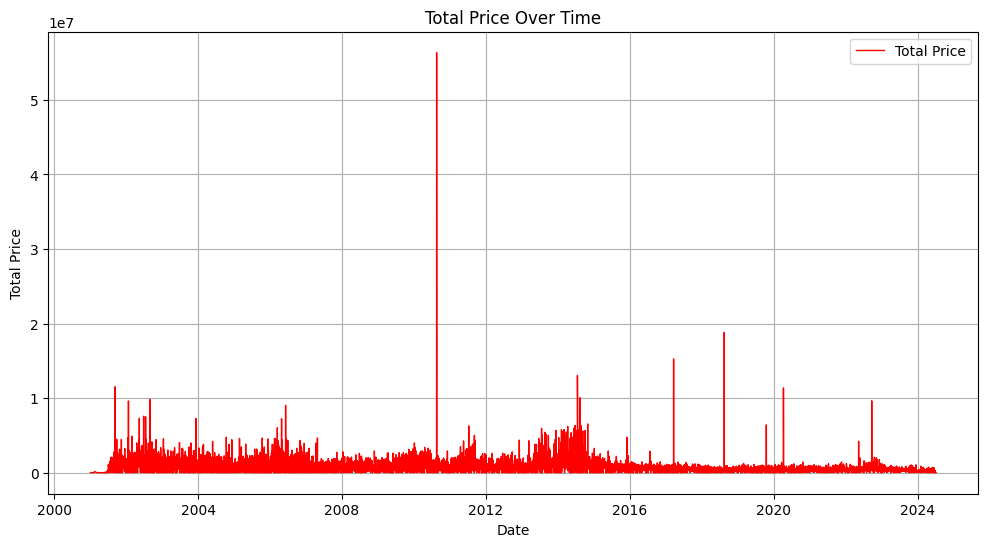

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Total Price Over Time
# Compute total price and aggregate by date
df_filtered["Total_Price"] = df_filtered["Quantity"] * df_filtered["Price"]
df_time_series_total = df_filtered.groupby("Date")["Total_Price"].sum()

# Plot total price over time
plt.figure(figsize=(12, 6))
plt.plot(df_time_series_total, color="red", linewidth=1, label="Total Price")
plt.xlabel("Date")
plt.ylabel("Total Price")
plt.title("Total Price Over Time")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Identify specific dates with highest total price (top revenue spikes)
top_revenue_spikes = df_time_series_total.sort_values(ascending=False).head()

# Display top 10 revenue spikes with dates
top_revenue_spikes


<b>Total Price Over Time </b>

    Trend Confirmed: Matches expected high variation over time.
    Revenue Spikes Detected: Significant peaks in 2012, 2016, 2020, and 2024.

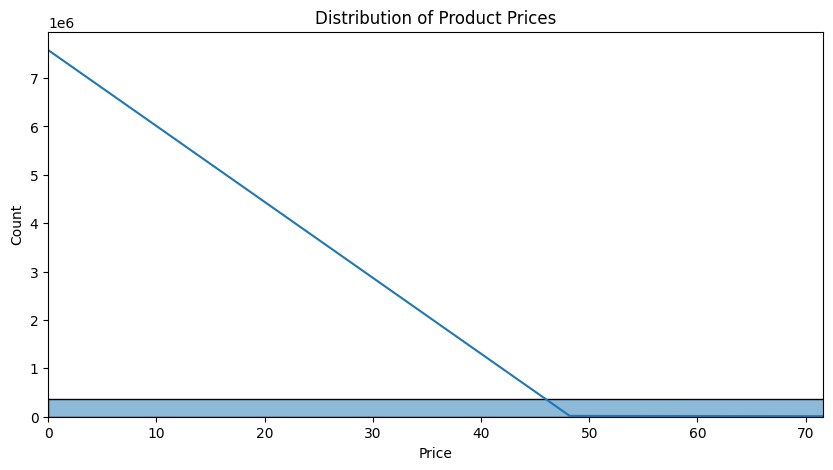

In [10]:
# 2. Price Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_filtered["Price"], bins=50, kde=True)
plt.xlim(0, df_filtered["Price"].quantile(0.99))  # Limit x-axis to exclude extreme outliers
plt.title("Distribution of Product Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

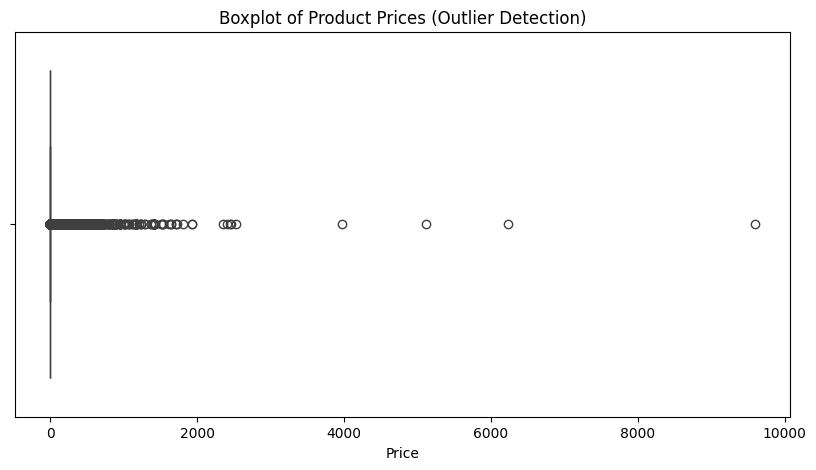

In [11]:
# 3. Boxplot of Price to visualize outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_filtered["Price"])
plt.title("Boxplot of Product Prices (Outlier Detection)")
plt.show()

<b> Price Distribution & Boxplot </b>

<b> Histogram: </b>

    Most prices are low, confirming a right-skewed distribution.
    The long tail effect is properly visualized.

<b> Boxplot: </b>

    Highlights significant outliers beyond 2000, 4000, 6000, 8000.
    Confirms the IQR-based outlier detection was necessary.

In [12]:
# Outlier Detection (IQR Method)
Q1 = df_filtered["Price"].quantile(0.25)
Q3 = df_filtered["Price"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [13]:
# Flag outliers instead of removing them
df_filtered["Price_Outlier"] = ((df_filtered["Price"] < lower_bound) | (df_filtered["Price"] > upper_bound)).astype(int)

# Count flagged outliers
df_filtered["Price_Outlier"].value_counts()

C:\Users\Alex\AppData\Local\Temp\ipykernel_13028\2931104048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Price_Outlier"] = ((df_filtered["Price"] < lower_bound) | (df_filtered["Price"] > upper_bound)).astype(int)


Price_Outlier
0    316056
1     45407
Name: count, dtype: int64

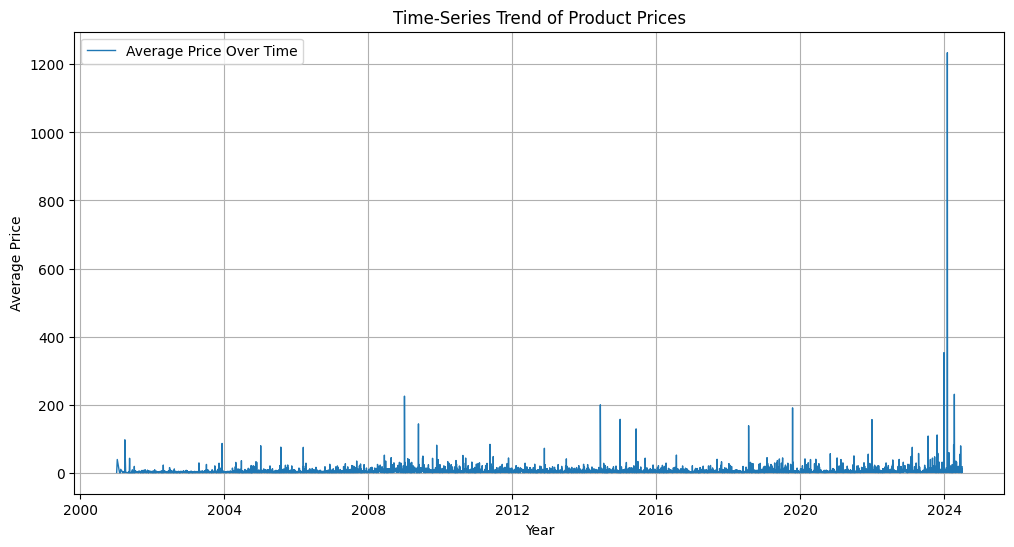

In [14]:
# Time-Series Trend Analysis
df_filtered = df_filtered.sort_values(by="Date")
df_time_series = df_filtered.groupby("Date")["Price"].mean()

plt.figure(figsize=(12, 6))
plt.plot(df_time_series, label="Average Price Over Time", linewidth=1)
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.title("Time-Series Trend of Product Prices")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Price Forecasting Using SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
sarima_model = SARIMAX(df_time_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 365))
sarima_result = sarima_model.fit()

C:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Alex\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Forecast next 365 days
forecast_steps = 365
sarima_forecast = sarima_result.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df_time_series.index[-1], periods=forecast_steps + 1, freq="D")[1:]

In [ ]:
# Convert forecast to DataFrame
sarima_forecast_df = pd.DataFrame({"Date": forecast_index, "Predicted_Price": sarima_forecast.predicted_mean})

In [ ]:
# Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(df_time_series, label="Historical Data", linewidth=1)
plt.plot(sarima_forecast_df["Date"], sarima_forecast_df["Predicted_Price"], label="SARIMA Forecast", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.title("SARIMA Forecast for Product Prices")
plt.legend()
plt.grid()
plt.show()